In [1]:
#Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

In [2]:
#Read the daily city-wise data
df= pd.read_csv("./air-quality-dataset/city_day.csv",parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
#Keeping only the columns needed
df=df[['City','Date','AQI']]

In [4]:
#Filtering the dataframe to keep the data for the city of Delhi only
delhi = df[df['City'] == 'Delhi']
delhi.drop(['City'],axis=1,inplace = True)
delhi.set_index('Date', inplace = True)


In [5]:
delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


In [6]:
#Fill NULL DATA
delhi['AQI'].fillna(method = 'bfill',inplace = True)

In [7]:
#Taking monthly average
delhi=delhi.astype('float64')
delhi=delhi.resample(rule='MS').mean()

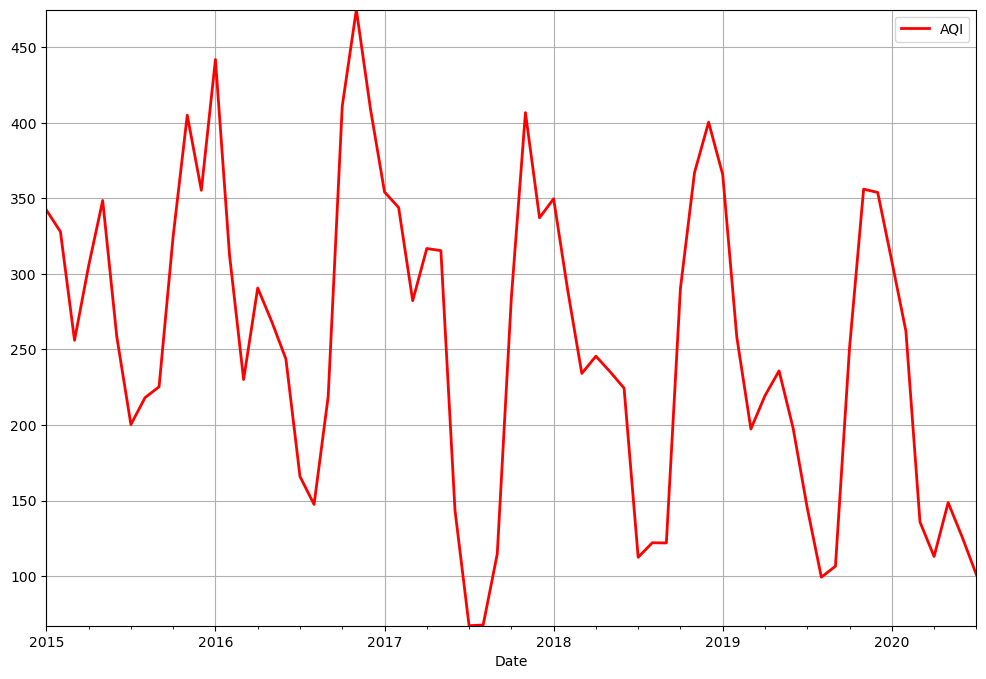

In [8]:
ax=delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

# FORECASTING


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

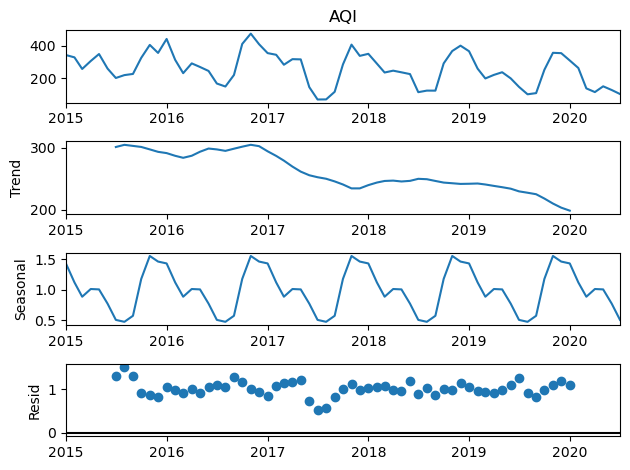

In [10]:
delhi_AQI=delhi['AQI']
result=seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot();

# **SARIMAX MODEL**

In [11]:
#Importing the SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
len(delhi_AQI)

67

In [13]:
#Splitting the training and testing dataset
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

In [14]:
#Defining our model and fitting on the training data
model=SARIMAX(train,order=(0,1,3),seasonal_order=(0,1,1,12))
results=model.fit()
results.summary()

C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -185.444
Date:                              Fri, 14 Apr 2023   AIC                            380.888
Time:                                      15:40:32   BIC                            388.665
Sample:                                  01-01-2015   HQIC                           383.573
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5592      8.359     -0.067      0.947     -16.943      15.824
ma.L2         -0.0811      3.710     -0.022      0.983      -7.353       7.190
ma.L3         -0.3560      3.137     -0.114      0.910      -6.504       5.792
ma.S.L12      -0.9980    131.189     -0.008      0.994    -258.123     256.127
sigma2      1325.5986   1.73e+05      0.008      0.994   -3.38e+05    3.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.43   Prob(JB):                         0.89
Heteroskedasticity (H):               0.54   Skew:                             0.20
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
#Predicting on our train and test dataset
train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')

<AxesSubplot: xlabel='Date'>

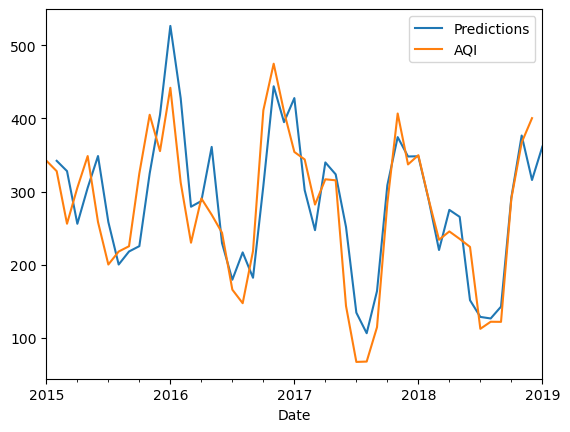

In [16]:
#Plotting the train predictions to see the fit of the model
train_predictions.plot(legend=True)
train.plot(legend=True)

In [17]:
#Calculating the RMSE value on the training dataset 
RMSE=np.sqrt(mean_squared_error(train_predictions,train))
print('RMSE = ',RMSE)
print('Mean AQI',train.mean())

RMSE =  66.39382515781044
Mean AQI 275.1711046334552


<AxesSubplot: xlabel='Date'>

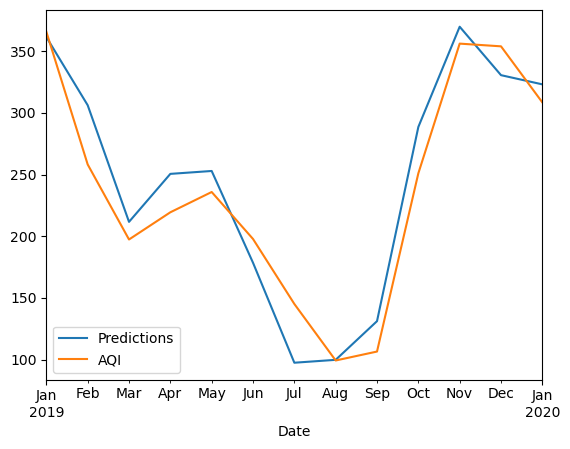

In [18]:
#Plotting the test predictions to see how well our model generalized
test_predictions.plot(legend=True)
test.plot(legend=True)

In [19]:
#Calculating the RMSE value on the testing dataset 
RMSE=np.sqrt(mean_squared_error(test_predictions,test))
print('RMSE = ',RMSE)
print('Mean AQI',test.mean())

RMSE =  26.878711331770837
Mean AQI 238.05046082949306


<AxesSubplot: xlabel='Date'>

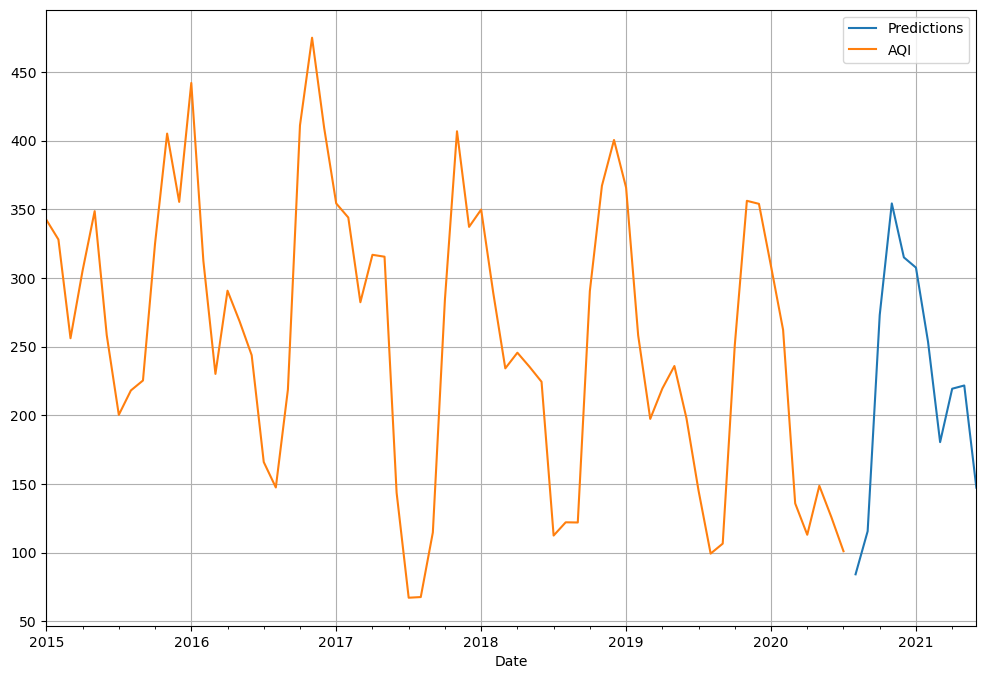

In [20]:
#Obtaining predicted values:
future_predictions = results.predict(start=67, end=77, typ='levels').rename('Predictions')

#Plotting predicted values against the true values:
future_predictions.plot(legend=True)
delhi_AQI.plot(legend=True,figsize=(12,8),grid=True)

### GRID search framework for fine tuning the model

In [21]:
def grid_search(p,d,q,P,D,Q,m,train,test):
    
    column_names = ['p','d','q','P','D','Q','m','RMSE_train','RMSE_test']
    df = pd.DataFrame(columns = column_names)

    for p1 in p:
        for p2 in d:
            for p3 in q:
                for p4 in P:
                    for p5 in D:
                        for p6 in Q:
                            for p7 in m:
                                
                                
                                model=SARIMAX(train,order=(p1,p2,p3),seasonal_order=(p4,p5,p6,p7))
                                try:
                                    results=model.fit()
                                except:
                                    print("Passing on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                    pass
                                print("Fitting on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                #results.summary()
                                #Predicting on our train and test dataset
                                train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
                                test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')
                                
                                #Calculating the RMSE value on the training dataset 
                                RMSE_train = np.sqrt(mean_squared_error(train_predictions,train))
                                #Calculating the RMSE value on the testing dataset 
                                RMSE_test=np.sqrt(mean_squared_error(test_predictions,test))
                                
                                #Fill our dataframe
                                df = df.append({'p':p1, 'd':p2,'q':p3,
                                                'P':p4,'D':p5,'Q':p6,'m':p7,
                                                'RMSE_train' : RMSE_train, 'RMSE_test' : RMSE_test},
                                               ignore_index = True)
                                print(df.tail(1))
                                
                                
                                
    return df

In [ ]:
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

p = [1,2,3,0]
d = [1,2,3,0]
q = [1,2,3,0]
P = [1,2,3,0]
D = [1,2,3,0]
Q = [1,2,3,0]
m = [12]

table = grid_search(p,d,q,P,D,Q,m,train,test)

Fitting on : 1 1 1 1 1 1 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
0  1.0  1.0  1.0  1.0  1.0  1.0  12.0   62.975716  37.275076


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 1 1 2 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
1  1.0  1.0  1.0  1.0  1.0  2.0  12.0   63.134707  46.541697
Fitting on : 1 1 1 1 1 3 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
2  1.0  1.0  1.0  1.0  1.0  3.0  12.0   62.957955  44.396351
Fitting on : 1 1 1 1 1 0 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
3  1.0  1.0  1.0  1.0  1.0  0.0  12.0    66.41462  44.756889


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 1 2 1 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
4  1.0  1.0  1.0  1.0  2.0  1.0  12.0   113.46108  66.617006


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 1 2 2 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
5  1.0  1.0  1.0  1.0  2.0  2.0  12.0  113.519627   59.31227


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 1 2 3 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
6  1.0  1.0  1.0  1.0  2.0  3.0  12.0  112.872715  53.482725
Fitting on : 1 1 1 1 2 0 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
7  1.0  1.0  1.0  1.0  2.0  0.0  12.0   113.69474  62.133932
Fitting on : 1 1 1 1 3 1 12
     p    d    q    P    D    Q     m  RMSE_train   RMSE_test
8  1.0  1.0  1.0  1.0  3.0  1.0  12.0  149.877714  289.379741


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 1 3 2 12
     p    d    q    P    D    Q     m  RMSE_train   RMSE_test
9  1.0  1.0  1.0  1.0  3.0  2.0  12.0  149.476827  293.431018


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 1 3 3 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
10  1.0  1.0  1.0  1.0  3.0  3.0  12.0   149.89264  286.618883
Fitting on : 1 1 1 1 3 0 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
11  1.0  1.0  1.0  1.0  3.0  0.0  12.0  149.387048  281.212918
Fitting on : 1 1 1 1 0 1 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
12  1.0  1.0  1.0  1.0  0.0  1.0  12.0   49.896223  111.295567


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 1 0 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
13  1.0  1.0  1.0  1.0  0.0  2.0  12.0   48.840488  89.809113


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 1 0 3 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
14  1.0  1.0  1.0  1.0  0.0  3.0  12.0   38.306065  112.301331
Fitting on : 1 1 1 1 0 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
15  1.0  1.0  1.0  1.0  0.0  0.0  12.0   53.898488  44.821203


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 1 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
16  1.0  1.0  1.0  2.0  1.0  1.0  12.0    62.12443  50.975877


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 1 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
17  1.0  1.0  1.0  2.0  1.0  2.0  12.0   62.373116  59.575162


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 1 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
18  1.0  1.0  1.0  2.0  1.0  3.0  12.0   62.346144  52.320405
Fitting on : 1 1 1 2 1 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
19  1.0  1.0  1.0  2.0  1.0  0.0  12.0   62.159785  41.662886


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 2 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
20  1.0  1.0  1.0  2.0  2.0  1.0  12.0  113.439535  90.550436


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 2 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
21  1.0  1.0  1.0  2.0  2.0  2.0  12.0  113.443676  89.974387


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 2 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
22  1.0  1.0  1.0  2.0  2.0  3.0  12.0  113.477587  86.487133


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 2 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
23  1.0  1.0  1.0  2.0  2.0  0.0  12.0  113.477559  91.198163
Fitting on : 1 1 1 2 3 1 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
24  1.0  1.0  1.0  2.0  3.0  1.0  12.0  157.283696  527.324337


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 3 2 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
25  1.0  1.0  1.0  2.0  3.0  2.0  12.0  149.233201  282.522028


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 3 3 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
26  1.0  1.0  1.0  2.0  3.0  3.0  12.0  151.741889  339.660052


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 3 0 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
27  1.0  1.0  1.0  2.0  3.0  0.0  12.0  150.939513  326.882876


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 0 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
28  1.0  1.0  1.0  2.0  0.0  1.0  12.0     49.3683  84.956625


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 0 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
29  1.0  1.0  1.0  2.0  0.0  2.0  12.0   48.826132    88.7631


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 2 0 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
30  1.0  1.0  1.0  2.0  0.0  3.0  12.0   48.974213  88.390437
Fitting on : 1 1 1 2 0 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
31  1.0  1.0  1.0  2.0  0.0  0.0  12.0   50.940147  67.838037
Fitting on : 1 1 1 3 1 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
32  1.0  1.0  1.0  3.0  1.0  1.0  12.0   62.686827  68.301568


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 1 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
33  1.0  1.0  1.0  3.0  1.0  2.0  12.0   62.796702  56.104564


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 1 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
34  1.0  1.0  1.0  3.0  1.0  3.0  12.0   62.315596  57.841767
Passing on : 1 1 1 3 1 0 12
Fitting on : 1 1 1 3 1 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
35  1.0  1.0  1.0  3.0  1.0  0.0  12.0   62.315596  57.841767


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 2 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
36  1.0  1.0  1.0  3.0  2.0  1.0  12.0  113.459045  91.599142


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 2 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
37  1.0  1.0  1.0  3.0  2.0  2.0  12.0  113.434673   88.36207


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 2 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
38  1.0  1.0  1.0  3.0  2.0  3.0  12.0  113.452746  90.083652


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 2 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
39  1.0  1.0  1.0  3.0  2.0  0.0  12.0   113.47872  90.507343
Fitting on : 1 1 1 3 3 1 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
40  1.0  1.0  1.0  3.0  3.0  1.0  12.0  156.646239  512.715506


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 3 2 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
41  1.0  1.0  1.0  3.0  3.0  2.0  12.0  150.974776  327.721886


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 3 3 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
42  1.0  1.0  1.0  3.0  3.0  3.0  12.0   149.74723  286.312274
Fitting on : 1 1 1 3 3 0 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
43  1.0  1.0  1.0  3.0  3.0  0.0  12.0  155.424933  477.080421


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 0 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
44  1.0  1.0  1.0  3.0  0.0  1.0  12.0   48.864868  82.036414
Fitting on : 1 1 1 3 0 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
45  1.0  1.0  1.0  3.0  0.0  2.0  12.0   49.996126  84.754171


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 0 3 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
46  1.0  1.0  1.0  3.0  0.0  3.0  12.0   49.076285  119.988555


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 3 0 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
47  1.0  1.0  1.0  3.0  0.0  0.0  12.0   48.887214  77.107702
Fitting on : 1 1 1 0 1 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
48  1.0  1.0  1.0  0.0  1.0  1.0  12.0   64.777994  29.026633
Fitting on : 1 1 1 0 1 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
49  1.0  1.0  1.0  0.0  1.0  2.0  12.0   63.019635  41.860041


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 0 1 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
50  1.0  1.0  1.0  0.0  1.0  3.0  12.0   63.176157  46.482406
Fitting on : 1 1 1 0 1 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
51  1.0  1.0  1.0  0.0  1.0  0.0  12.0   73.876233  29.187681
Fitting on : 1 1 1 0 2 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
52  1.0  1.0  1.0  0.0  2.0  1.0  12.0  112.272087  35.976651


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 0 2 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
53  1.0  1.0  1.0  0.0  2.0  2.0  12.0  112.855904  53.639558


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 0 2 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
54  1.0  1.0  1.0  0.0  2.0  3.0  12.0  113.387336  73.333884
Fitting on : 1 1 1 0 2 0 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
55  1.0  1.0  1.0  0.0  2.0  0.0  12.0  116.188451  125.740834


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 0 3 1 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
56  1.0  1.0  1.0  0.0  3.0  1.0  12.0  149.064519  275.010359


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 0 3 2 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
57  1.0  1.0  1.0  0.0  3.0  2.0  12.0  149.505666  296.537092


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 0 3 3 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
58  1.0  1.0  1.0  0.0  3.0  3.0  12.0  150.600067  304.397517
Fitting on : 1 1 1 0 3 0 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
59  1.0  1.0  1.0  0.0  3.0  0.0  12.0  149.873764  289.259187
Fitting on : 1 1 1 0 0 1 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
60  1.0  1.0  1.0  0.0  0.0  1.0  12.0   32.421555  185.681975
Fitting on : 1 1 1 0 0 2 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
61  1.0  1.0  1.0  0.0  0.0  2.0  12.0   38.268254  112.097706


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 1 0 0 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
62  1.0  1.0  1.0  0.0  0.0  3.0  12.0   41.413968  96.483733
Fitting on : 1 1 1 0 0 0 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
63  1.0  1.0  1.0  0.0  0.0  0.0  12.0   28.137682  218.370763
Fitting on : 1 1 2 1 1 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
64  1.0  1.0  2.0  1.0  1.0  1.0  12.0   64.413777  38.853085


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 1 1 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
65  1.0  1.0  2.0  1.0  1.0  2.0  12.0    64.80398  51.088458


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 1 1 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
66  1.0  1.0  2.0  1.0  1.0  3.0  12.0   64.707517  51.453517
Fitting on : 1 1 2 1 1 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
67  1.0  1.0  2.0  1.0  1.0  0.0  12.0   67.426179  46.112136


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 1 2 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
68  1.0  1.0  2.0  1.0  2.0  1.0  12.0  112.281479   64.39849


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 1 2 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
69  1.0  1.0  2.0  1.0  2.0  2.0  12.0  114.511192  76.264934


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 1 2 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
70  1.0  1.0  2.0  1.0  2.0  3.0  12.0  112.310877  52.847234
Fitting on : 1 1 2 1 2 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
71  1.0  1.0  2.0  1.0  2.0  0.0  12.0  112.963119  61.790242
Fitting on : 1 1 2 1 3 1 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
72  1.0  1.0  2.0  1.0  3.0  1.0  12.0   149.52998  281.697193


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 1 3 2 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
73  1.0  1.0  2.0  1.0  3.0  2.0  12.0  149.458532  280.098062
Fitting on : 1 1 2 1 3 3 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
74  1.0  1.0  2.0  1.0  3.0  3.0  12.0  150.009619  286.680534
Fitting on : 1 1 2 1 3 0 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
75  1.0  1.0  2.0  1.0  3.0  0.0  12.0  149.600839  285.250195
Fitting on : 1 1 2 1 0 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
76  1.0  1.0  2.0  1.0  0.0  1.0  12.0   54.448247    56.0885


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 1 0 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
77  1.0  1.0  2.0  1.0  0.0  2.0  12.0   53.586029  58.835767


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 1 0 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
78  1.0  1.0  2.0  1.0  0.0  3.0  12.0    47.06574  54.816372
Fitting on : 1 1 2 1 0 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
79  1.0  1.0  2.0  1.0  0.0  0.0  12.0   53.605411  44.942206


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 1 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
80  1.0  1.0  2.0  2.0  1.0  1.0  12.0   63.527192  52.888792
Fitting on : 1 1 2 2 1 2 12
      p    d    q    P    D    Q     m  RMSE_train    RMSE_test
81  1.0  1.0  2.0  2.0  1.0  2.0  12.0  709.506978  1158.663832


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 1 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
82  1.0  1.0  2.0  2.0  1.0  3.0  12.0   64.443896  29.609255
Fitting on : 1 1 2 2 1 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
83  1.0  1.0  2.0  2.0  1.0  0.0  12.0   63.545467   42.93619


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 2 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
84  1.0  1.0  2.0  2.0  2.0  1.0  12.0   111.88022  91.541301


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 2 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
85  1.0  1.0  2.0  2.0  2.0  2.0  12.0  111.862116  90.719646


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 2 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
86  1.0  1.0  2.0  2.0  2.0  3.0  12.0  112.440568  61.913465


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 2 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
87  1.0  1.0  2.0  2.0  2.0  0.0  12.0  111.925951   88.53862


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 3 1 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
88  1.0  1.0  2.0  2.0  3.0  1.0  12.0  150.903339  312.943145


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 3 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
89  1.0  1.0  2.0  2.0  3.0  2.0  12.0  151.133835   320.1702


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 3 3 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
90  1.0  1.0  2.0  2.0  3.0  3.0  12.0  151.032058  317.733695


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 2 3 0 12
      p    d    q    P    D    Q     m  RMSE_train   RMSE_test
91  1.0  1.0  2.0  2.0  3.0  0.0  12.0  151.346197  327.413239
Fitting on : 1 1 2 2 0 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
92  1.0  1.0  2.0  2.0  0.0  1.0  12.0   48.225378  77.873912
Passing on : 1 1 2 2 0 2 12
Fitting on : 1 1 2 2 0 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
93  1.0  1.0  2.0  2.0  0.0  2.0  12.0   48.225378  77.873912
Passing on : 1 1 2 2 0 3 12
Fitting on : 1 1 2 2 0 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
94  1.0  1.0  2.0  2.0  0.0  3.0  12.0   48.225378  77.873912
Fitting on : 1 1 2 2 0 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
95  1.0  1.0  2.0  2.0  0.0  0.0  12.0   55.758585  50.816997


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 1 1 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
96  1.0  1.0  2.0  3.0  1.0  1.0  12.0   64.202241  76.697482
Fitting on : 1 1 2 3 1 2 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
97  1.0  1.0  2.0  3.0  1.0  2.0  12.0   64.379202  75.304622
Passing on : 1 1 2 3 1 3 12
Fitting on : 1 1 2 3 1 3 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
98  1.0  1.0  2.0  3.0  1.0  3.0  12.0   64.379202  75.304622


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 1 0 12
      p    d    q    P    D    Q     m  RMSE_train  RMSE_test
99  1.0  1.0  2.0  3.0  1.0  0.0  12.0   64.260091  77.192122


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 2 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
100  1.0  1.0  2.0  3.0  2.0  1.0  12.0   111.86107  92.715144


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 2 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
101  1.0  1.0  2.0  3.0  2.0  2.0  12.0  111.877984   84.42862


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 2 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
102  1.0  1.0  2.0  3.0  2.0  3.0  12.0  111.945537  82.312845


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 2 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
103  1.0  1.0  2.0  3.0  2.0  0.0  12.0  111.879246  87.804747


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 3 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
104  1.0  1.0  2.0  3.0  3.0  1.0  12.0  151.165211  320.25556


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 3 2 12
       p    d    q    P    D    Q     m  RMSE_train   RMSE_test
105  1.0  1.0  2.0  3.0  3.0  2.0  12.0  151.247948  324.386191


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 3 3 12
       p    d    q    P    D    Q     m  RMSE_train   RMSE_test
106  1.0  1.0  2.0  3.0  3.0  3.0  12.0  151.251059  323.488481


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 3 0 12
       p    d    q    P    D    Q     m  RMSE_train   RMSE_test
107  1.0  1.0  2.0  3.0  3.0  0.0  12.0  151.994443  350.809163
Fitting on : 1 1 2 3 0 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
108  1.0  1.0  2.0  3.0  0.0  1.0  12.0   53.920695  62.591728


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 3 0 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
109  1.0  1.0  2.0  3.0  0.0  2.0  12.0   53.836534  63.595563
Passing on : 1 1 2 3 0 3 12
Fitting on : 1 1 2 3 0 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
110  1.0  1.0  2.0  3.0  0.0  3.0  12.0   53.836534  63.595563
Fitting on : 1 1 2 3 0 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
111  1.0  1.0  2.0  3.0  0.0  0.0  12.0   54.019529  59.149332
Fitting on : 1 1 2 0 1 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
112  1.0  1.0  2.0  0.0  1.0  1.0  12.0   64.533372  29.336132


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 0 1 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
113  1.0  1.0  2.0  0.0  1.0  2.0  12.0   64.100294  42.187134


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 0 1 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
114  1.0  1.0  2.0  0.0  1.0  3.0  12.0    64.69231   51.01671
Fitting on : 1 1 2 0 1 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
115  1.0  1.0  2.0  0.0  1.0  0.0  12.0   73.778668  29.463745
Fitting on : 1 1 2 0 2 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
116  1.0  1.0  2.0  0.0  2.0  1.0  12.0  112.616692  35.578179


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 0 2 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
117  1.0  1.0  2.0  0.0  2.0  2.0  12.0  112.315662  53.022564


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 0 2 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
118  1.0  1.0  2.0  0.0  2.0  3.0  12.0  112.113828   70.91406
Fitting on : 1 1 2 0 2 0 12
       p    d    q    P    D    Q     m  RMSE_train   RMSE_test
119  1.0  1.0  2.0  0.0  2.0  0.0  12.0  116.256178  107.136733
Fitting on : 1 1 2 0 3 1 12
       p    d    q    P    D    Q     m  RMSE_train   RMSE_test
120  1.0  1.0  2.0  0.0  3.0  1.0  12.0  149.612639  282.638351
Fitting on : 1 1 2 0 3 2 12
       p    d    q    P    D    Q     m  RMSE_train   RMSE_test
121  1.0  1.0  2.0  0.0  3.0  2.0  12.0  150.448097  295.818974


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 0 3 3 12
       p    d    q    P    D    Q     m  RMSE_train   RMSE_test
122  1.0  1.0  2.0  0.0  3.0  3.0  12.0  149.899796  284.513444
Fitting on : 1 1 2 0 3 0 12
       p    d    q    P    D    Q     m  RMSE_train   RMSE_test
123  1.0  1.0  2.0  0.0  3.0  0.0  12.0  150.433997  297.662686
Fitting on : 1 1 2 0 0 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
124  1.0  1.0  2.0  0.0  0.0  1.0  12.0   39.695264  75.305847


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 0 0 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
125  1.0  1.0  2.0  0.0  0.0  2.0  12.0   47.158394  54.680848


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 2 0 0 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
126  1.0  1.0  2.0  0.0  0.0  3.0  12.0   49.477706  47.531757
Fitting on : 1 1 2 0 0 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
127  1.0  1.0  2.0  0.0  0.0  0.0  12.0   34.050067  99.565327
Fitting on : 1 1 3 1 1 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
128  1.0  1.0  3.0  1.0  1.0  1.0  12.0   64.291209  38.383645


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 1 1 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
129  1.0  1.0  3.0  1.0  1.0  2.0  12.0   62.354043  39.662466


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 1 1 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
130  1.0  1.0  3.0  1.0  1.0  3.0  12.0   64.287555   47.36492
Fitting on : 1 1 3 1 1 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
131  1.0  1.0  3.0  1.0  1.0  0.0  12.0   67.654163  46.573663


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 1 2 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
132  1.0  1.0  3.0  1.0  2.0  1.0  12.0  112.692307  68.130837


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 1 2 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
133  1.0  1.0  3.0  1.0  2.0  2.0  12.0  113.401806  60.779771


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 1 2 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
134  1.0  1.0  3.0  1.0  2.0  3.0  12.0  113.028201  53.185141


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 1 2 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
135  1.0  1.0  3.0  1.0  2.0  0.0  12.0  114.285368  62.403968
Passing on : 1 1 3 1 3 1 12
Fitting on : 1 1 3 1 3 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
136  1.0  1.0  3.0  1.0  3.0  1.0  12.0  114.285368  62.403968
Passing on : 1 1 3 1 3 2 12
Fitting on : 1 1 3 1 3 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
137  1.0  1.0  3.0  1.0  3.0  2.0  12.0  114.285368  62.403968
Passing on : 1 1 3 1 3 3 12
Fitting on : 1 1 3 1 3 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
138  1.0  1.0  3.0  1.0  3.0  3.0  12.0  114.285368  62.403968
Passing on : 1 1 3 1 3 0 12
Fitting on : 1 1 3 1 3 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
139  1.0  1.0  3.0  1.0  3.0  0.0  12.0  114.285368  62.403968
Fitting on : 1 1 3 1 0 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
140  1.0  1.0  3.0  1.0  0.

C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 1 0 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
141  1.0  1.0  3.0  1.0  0.0  2.0  12.0   53.213456  65.275795


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 1 0 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
142  1.0  1.0  3.0  1.0  0.0  3.0  12.0   47.016127  54.374358
Fitting on : 1 1 3 1 0 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
143  1.0  1.0  3.0  1.0  0.0  0.0  12.0    53.88782  44.180554


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 1 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
144  1.0  1.0  3.0  2.0  1.0  1.0  12.0   64.607851  47.556489


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 1 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
145  1.0  1.0  3.0  2.0  1.0  2.0  12.0   68.202949  59.463007


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 1 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
146  1.0  1.0  3.0  2.0  1.0  3.0  12.0   67.949416  63.351053
Fitting on : 1 1 3 2 1 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
147  1.0  1.0  3.0  2.0  1.0  0.0  12.0   63.268517  43.739106


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 2 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
148  1.0  1.0  3.0  2.0  2.0  1.0  12.0  112.013502  91.814116


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 2 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
149  1.0  1.0  3.0  2.0  2.0  2.0  12.0  112.282948  85.692305


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 2 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
150  1.0  1.0  3.0  2.0  2.0  3.0  12.0  112.381379  74.960122


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 2 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
151  1.0  1.0  3.0  2.0  2.0  0.0  12.0  112.024261  92.321238
Passing on : 1 1 3 2 3 1 12
Fitting on : 1 1 3 2 3 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
152  1.0  1.0  3.0  2.0  3.0  1.0  12.0  112.024261  92.321238
Passing on : 1 1 3 2 3 2 12
Fitting on : 1 1 3 2 3 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
153  1.0  1.0  3.0  2.0  3.0  2.0  12.0  112.024261  92.321238
Passing on : 1 1 3 2 3 3 12
Fitting on : 1 1 3 2 3 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
154  1.0  1.0  3.0  2.0  3.0  3.0  12.0  112.024261  92.321238
Passing on : 1 1 3 2 3 0 12
Fitting on : 1 1 3 2 3 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
155  1.0  1.0  3.0  2.0  3.0  0.0  12.0  112.024261  92.321238


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 0 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
156  1.0  1.0  3.0  2.0  0.0  1.0  12.0   55.718558  37.953817


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 0 2 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
157  1.0  1.0  3.0  2.0  0.0  2.0  12.0   51.620809  52.192986


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 0 3 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
158  1.0  1.0  3.0  2.0  0.0  3.0  12.0   53.340452   80.01829


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting on : 1 1 3 2 0 0 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
159  1.0  1.0  3.0  2.0  0.0  0.0  12.0   54.404415  50.417966
Passing on : 1 1 3 3 1 1 12
Fitting on : 1 1 3 3 1 1 12
       p    d    q    P    D    Q     m  RMSE_train  RMSE_test
160  1.0  1.0  3.0  3.0  1.0  1.0  12.0   54.404415  50.417966


C:\Users\veena\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
table

In [ ]:
table.to_csv("grid-search-results.csv")